In [1]:
#TODO: check low r2 of gain only model

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

import scienceplots
import shutup

from joblib import Parallel, delayed

from lib import data, spks_utils, fitlvm_utils, fit_models, eval_models, models, utils

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
# pretty plots
plt.style.use(['nature'])
plt.rcParams['figure.dpi'] = 200
%matplotlib widget
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

# seed and suppress warnings :-)
fit_models.seed()
shutup.please()

In [3]:
trial_data_all = np.load("vars/trial_data_all_MM012_MM013_5sess.npz", allow_pickle=True)['arr_0']
session_data_all = np.load("vars/session_data_all_MM012_MM013_5sess.npy", allow_pickle=True)
unit_spike_times_all = np.load("vars/unit_spike_times_all_MM012_MM013_5sess.npy", allow_pickle=True)
regions_all = np.load("vars/regions_all.npy", allow_pickle=True)

## NB

In [4]:
subj_idx = 1; sess_idx = 3

unit_spike_times = unit_spike_times_all[subj_idx][sess_idx]
trial_data = trial_data_all[subj_idx][sess_idx]
session_data = session_data_all[subj_idx][sess_idx]
regions = regions_all[subj_idx][sess_idx]

In [6]:
psths, _, _, _, _, _, mask = data.get_psths(unit_spike_times, trial_data, session_data, regions, 
                                tpre=0.5, tpost=0.5, binwidth_ms=25, alignment='choice', 
                            balance=True, reward_only=False, do_rem_zstd=True, shuffle=False, prev_filter=False)
trial_data = trial_data[mask]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ntents=5
data_gd, train_dl, val_dl, test_dl, train_inds, val_inds, test_inds, Mtrain, Mtest, sample, num_trials, num_tv, num_units = fitlvm_utils.get_data_model(psths, trial_data, regions, norm=False, num_tents=ntents, task_vars=['response', 'rewarded', 'response_prev', 'rewarded_prev'])

48 124 64 82
originally 145 units
good units 145
318 Trials, 145 Neurons


Step 0
Found 71 /145 units with stable low-dimensional structure at rank 1
Step 1: Baseline
Fitting baseline model...done
Step 2: Task Var
Fitting task variable model...done
Step 2a: Eval


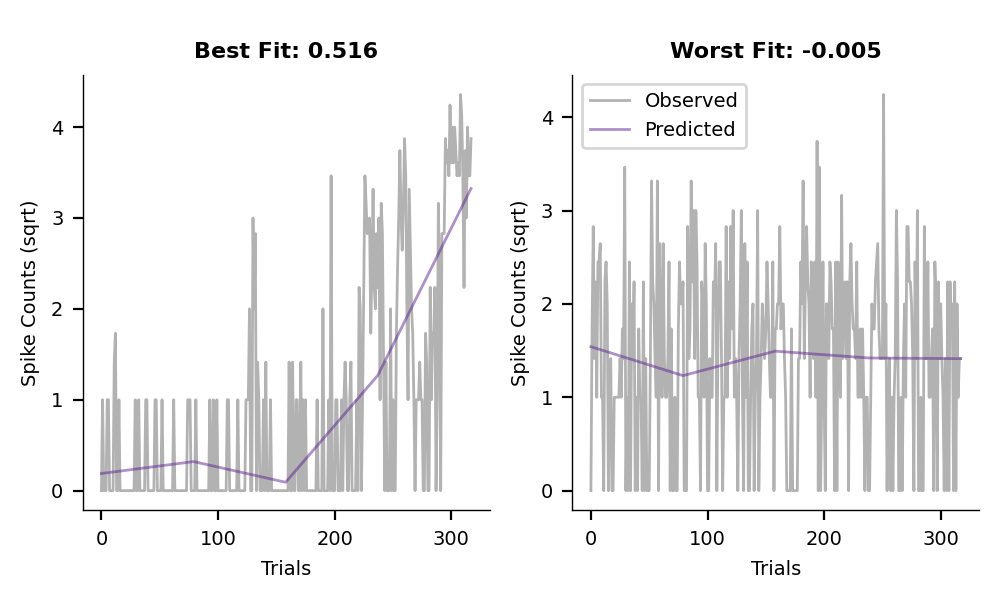

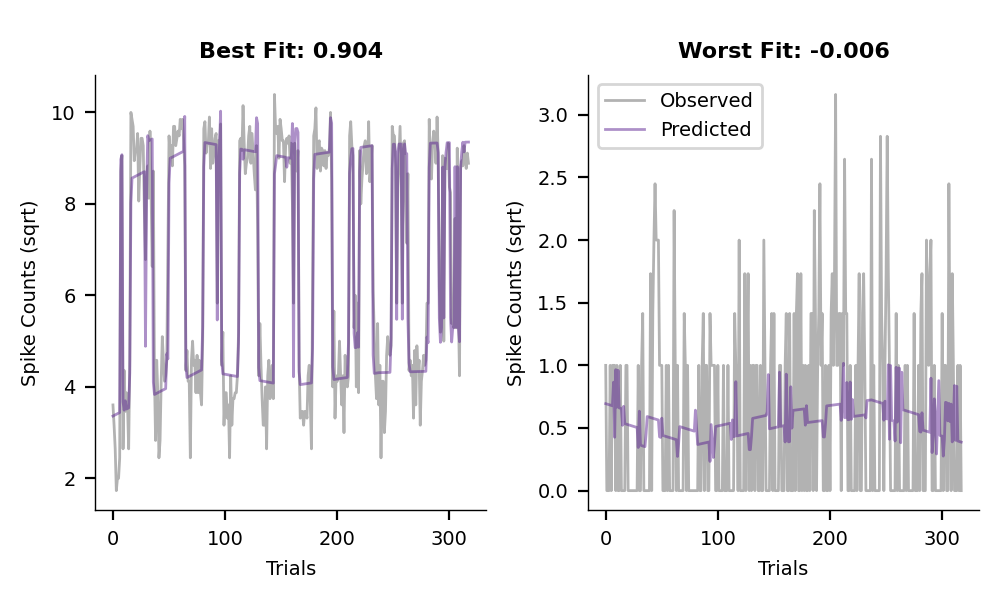

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


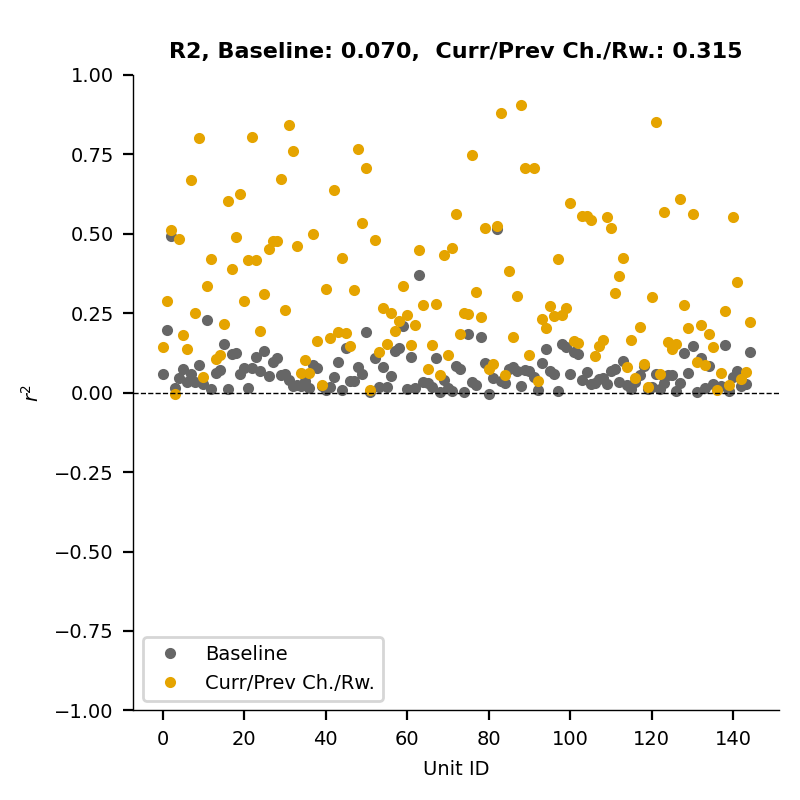

Step3a: Inclusion Criteria
Found 144 /145 units with significant task variable + drift model
144 141
Using 145 total units for modeling


In [7]:
# MODELING
# Step 0: Check if dataset has stable low-dim structure at 4+ dims
print("Step 0")
cids_pca = fitlvm_utils.check_stable_lowd(data_gd, Mtrain, Mtest, num_units)

# Step 1: Fit baseline model
# > Baseline model: has no task vars, can capture slow drift in firing rate for each unit using b0-splines
print("Step 1: Baseline")
mod_baseline = fitlvm_utils.fit_baseline(train_dl, val_dl, num_tv, num_units, ntents=ntents)

# Step 2: Fit model with task vars and slow drift
# > Task vars & slow drift: Used to identify units driven by task vars
print("Step 2: Task Var")
mod_tv = fitlvm_utils.fit_tvs(train_dl, val_dl, num_tv, num_units, mod_baseline, ntents=ntents) 

# Step 2a: Evaluate and plot comparison for baseline and task variable models
print("Step 2a: Eval")
res_baseline        = fitlvm_utils.eval_model(mod_baseline, data_gd, test_dl.dataset, do_plot=True, save=False)
res_tv              = fitlvm_utils.eval_model(mod_tv, data_gd, test_dl.dataset, do_plot=True, save=False)
fitlvm_utils.plot_r2_comp(res_baseline, res_tv, label_a="Baseline", label_b="Curr/Prev Ch./Rw.", save=False)

# Step 3a: Get units that had significant performance increase with a task variable model
print("Step3a: Inclusion Criteria")
cids = fitlvm_utils.get_cids(cids_pca, res_tv)

In [12]:
from scipy.stats import rankdata

def spearmanr_vec(x, y):
    # x is one vector, y is a matrix, correlate x with y[:,i]
    xr = rankdata(x)
    yr = np.vstack([rankdata(y[:, i]) for i in range(y.shape[1])]).T

    xr -= xr.mean()
    yr -= yr.mean(axis=0)

    return (xr[:, None] * yr).sum(0) / (
        np.sqrt((xr**2).sum()) *
        np.sqrt((yr**2).sum(0))
    )

# res_block_corr = spearmanr_vec(block_side, res)
# assert (res_block_corr == [spearmanr(block_side, res[:,i]).statistic for i in range(res.shape[1])]).all

In [13]:
from copy import deepcopy
mod_tv_nolatent = deepcopy(mod_tv)
# mod_tv_nolatent.readout_offset.weight.data[:] = 0
res_tv_nolatent = fitlvm_utils.eval_model(mod_tv, data_gd, test_dl.dataset)

robs = val_dl.dataset[:]['robs']
rhat = res_tv_nolatent['rhat']
res = robs - rhat

block_side = np.where(trial_data['block_side']=='left', 1, -1)
choice = trial_data['response']
reward = trial_data['rewarded']

rob_block_corr = utils.spearmanr_vec(block_side, robs)
rob_choice_corr = utils.spearmanr_vec(choice, robs)
rob_reward_corr = utils.spearmanr_vec(reward, robs)
res_block_corr = utils.spearmanr_vec(block_side, res)
res_choice_corr = utils.spearmanr_vec(choice, res)
res_reward_corr = utils.spearmanr_vec(reward, res)

C:\Users\danci\AppData\Local\Temp\ipykernel_9432\2576209810.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  res = robs - rhat


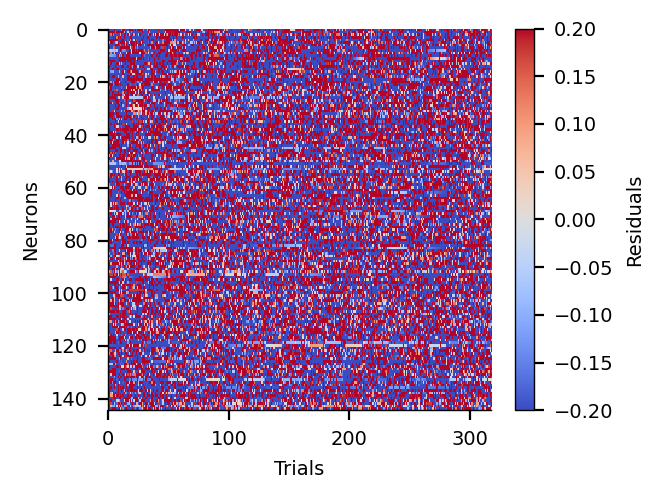

In [14]:
plt.figure()
plt.imshow(res.T, aspect='auto', interpolation='none', cmap='coolwarm', vmin=-0.2, vmax=0.2)
plt.colorbar(label="Residuals")
plt.xlabel("Trials"); plt.ylabel("Neurons")
plt.tight_layout(); plt.show()

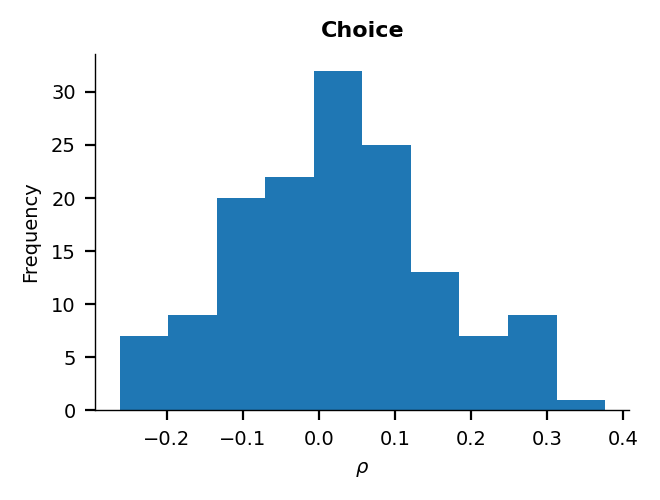

In [15]:
plt.figure() 
plt.hist(res_block_corr)
plt.xlabel(r"$\rho$")
plt.ylabel("Frequency")
plt.title("Choice")
plt.tight_layout(); plt.show()

In [ ]:
# look at where neurons with high coupling weight fall in the correlation histogram
# find residuals from task variable model after latent fit
# set max_iter to 1 st it does not refit the task variables

In [72]:
res_block_corr[np.argmax(res_tv['r2test'])]

np.float64(0.13807956366681318)

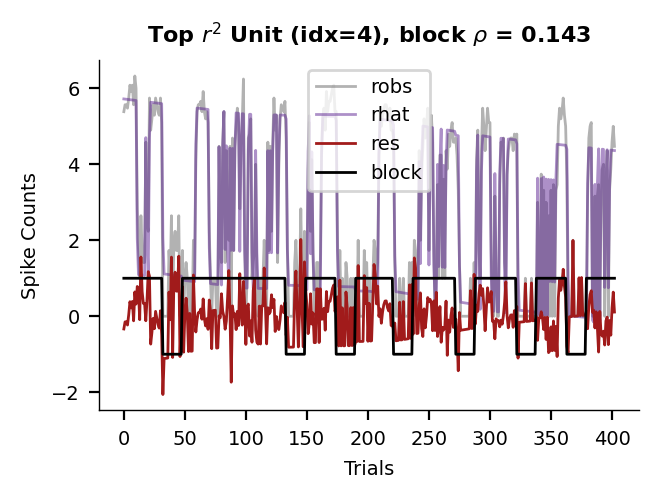

In [88]:
plt.figure()
plt.plot(robs[:,np.argmax(res_tv['r2test'])], color="#666666", alpha=0.5, label="robs")
plt.plot(rhat[:,np.argmax(res_tv['r2test'])], color="#5C2392", alpha=0.5, label="rhat")
plt.plot(res[:,np.argmax(res_tv['r2test'])], color="#A11B1B", label="res")
plt.plot(block_side, color="#000000", label='block')
plt.xlabel("Trials")
plt.ylabel("Spike Counts")
plt.title(fr"Top $r^2$ Unit (idx={np.argmax(res_tv['r2test'])}), block $\rho$ = {res_block_corr[np.argmax(res_tv['r2test'])].round(3)}")
plt.legend()
plt.tight_layout(); plt.show()

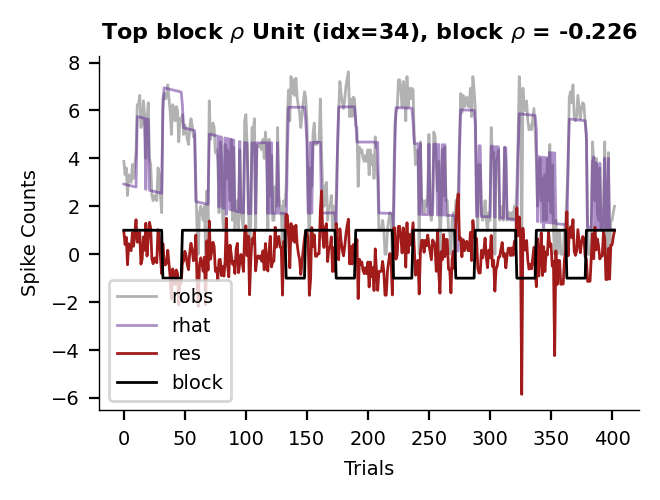

In [89]:
plt.figure()
plt.plot(robs[:,np.argmax(np.abs(res_block_corr))], color="#666666", alpha=0.5, label="robs")
plt.plot(rhat[:,np.argmax(np.abs(res_block_corr))], color="#5C2392", alpha=0.5, label="rhat")
plt.plot(res[:,np.argmax(np.abs(res_block_corr))], color="#A11B1B", label="res")
plt.plot(block_side, color="#000000", label='block')
plt.xlabel("Trials")
plt.ylabel("Spike Counts")
plt.title(fr"Top block $\rho$ Unit (idx={np.argmax(np.abs(res_block_corr))}), block $\rho$ = {res_block_corr[np.argmax(np.abs(res_block_corr))].round(3)}")
plt.legend()
plt.tight_layout(); plt.show()

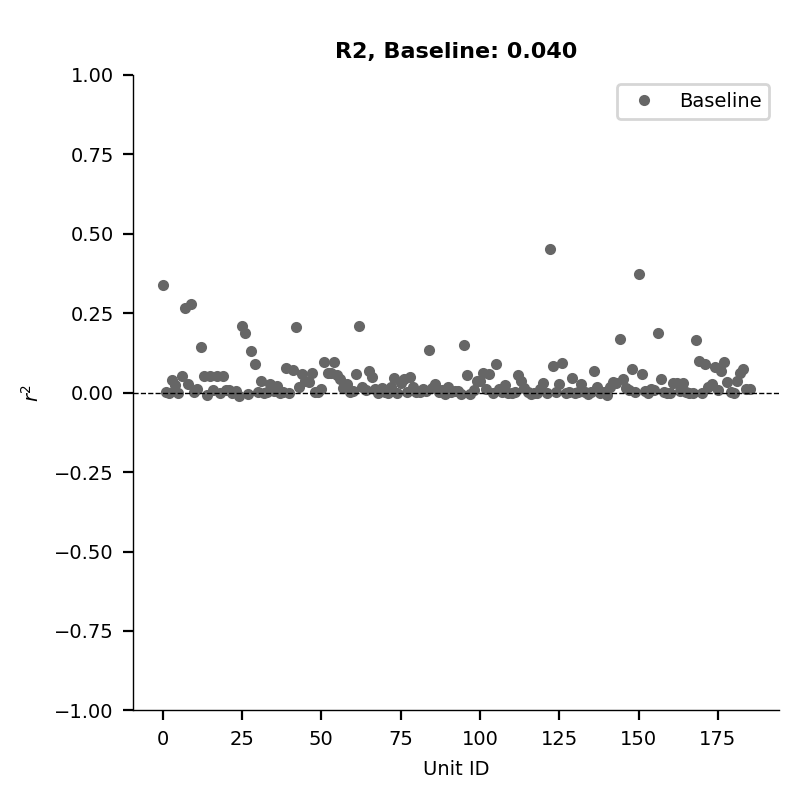

In [18]:
fitlvm_utils.plot_r2(res_baseline, label_a="Baseline", save=False)

In [8]:
# # Step 3b: Fit gain autoencoder
# # # NOTE: fitting done by first fixing drift/tv, first pass fit latent weights; then refit drift/tv and latents independently
print("Step 3b: Gain AE")
mod_ae_gain = fitlvm_utils.fit_ae_gain(train_dl, val_dl, mod_tv, cids, num_tv, num_units, data_gd, num_latents=1, max_iter=0) 

# Step 3c: Fit offset autoencoder
print("Step 3c: Offset AE")
mod_ae_offset = fitlvm_utils.fit_ae_offset(train_dl, val_dl, mod_tv, cids, num_tv, num_units, data_gd, num_latents=1, max_iter=0)

# # Step 3d: Fit affine autoencoder
print("Step 3d: Affine AE")
mod_ae_affine, r2 = fitlvm_utils.fit_ae_affine(train_dl, val_dl, test_dl, mod_tv, mod_ae_gain, mod_ae_offset, cids, num_tv, num_units, data_gd, device, num_latents=1, max_iter=0)


Step 3b: Gain AE
Fitting gain autoencoder...Initial: -1.7494
Fit latents: -1.7494, 0.3514
Done
Step 3c: Offset AE
Fitting offset autoencoder...
Initial: -1.2790
Fit latents: -1.2790, 0.3532
Done
Step 3d: Affine AE
Fitting affine autoencoder...Initial: 0.3085
Fit latents: 0.3085, 0.3741
Done
Autoencoder iter 0, val r2: 0.3741
confirming model r2 = 0.3741


Step 3e: Eval


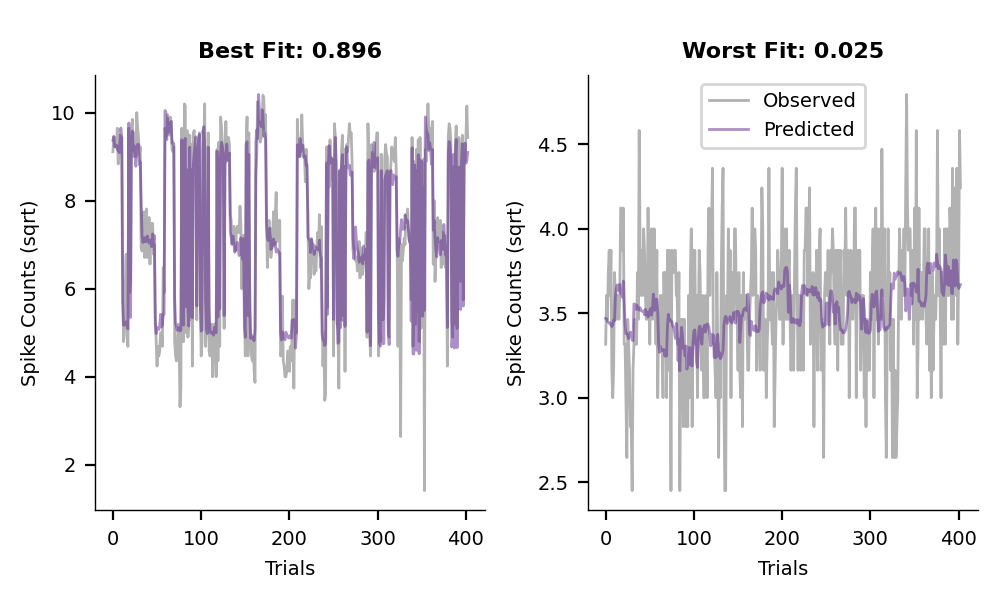

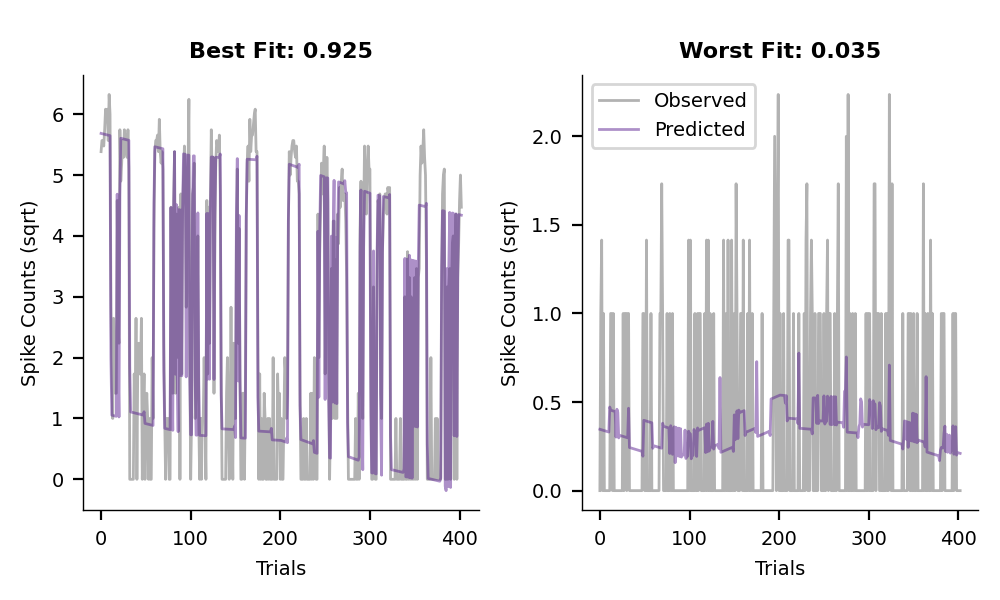

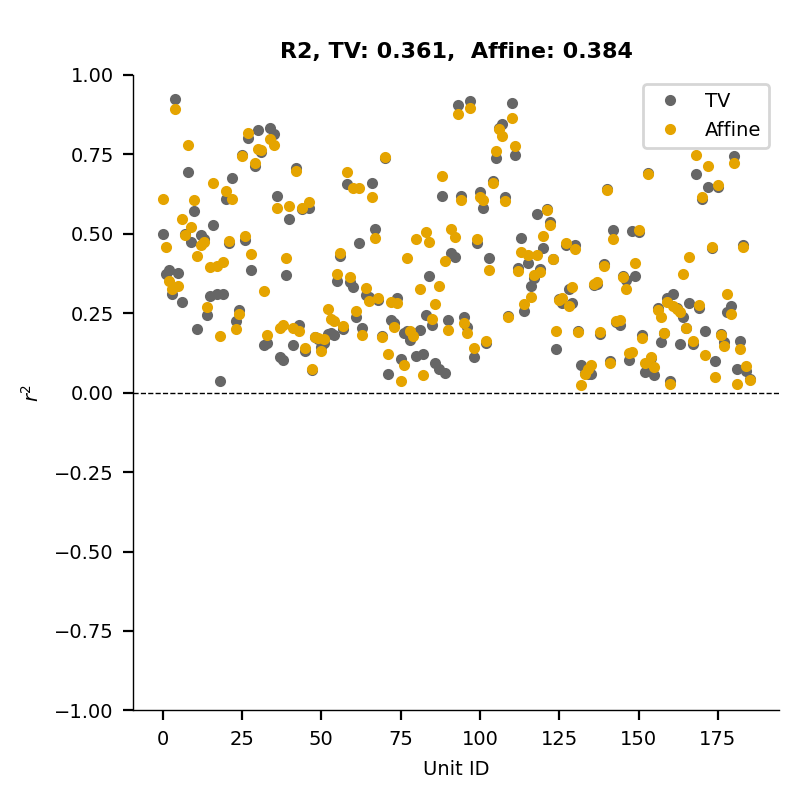

In [8]:
print("Step 3e: Eval")
res_affineae        = fitlvm_utils.eval_model(mod_ae_affine, data_gd, test_dl.dataset, do_plot=True, save=False)
res_tv              = fitlvm_utils.eval_model(mod_tv, data_gd, test_dl.dataset, do_plot=True, save=False)
_ = fitlvm_utils.plot_r2_comp(res_tv, res_affineae, label_a="TV", label_b="Affine", save=False)

In [9]:
# Step 4a: Convert ae to lvm
# NOTE: the difference between affine and affineae is that affineae (step 3) is fit with weights initialized by an autoencoder
print("Step 4a: AE to LVM")
mod_ae_offset_lvm, mod_ae_gain_lvm, mod_ae_affine_lvm = fitlvm_utils.ae2lvm(train_dl, val_dl, mod_ae_offset, mod_ae_gain, mod_ae_affine, cids, num_tv, num_units, data_gd, num_latents=1, max_iters=0)


Step 4a: AE to LVM
Initial: 0.3532
Fit latents: 0.3532, 0.3394
Fit run 0.000,0.010: 0.3394
Initial: 0.3514
Fit latents: 0.3514, 0.3389
Fit run 0.010,0.000: 0.3389
Initial: 0.3741
Fit latents: 0.3741, 0.3584
Fit run 0.010,0.010: 0.3584


Step 4b: Eval


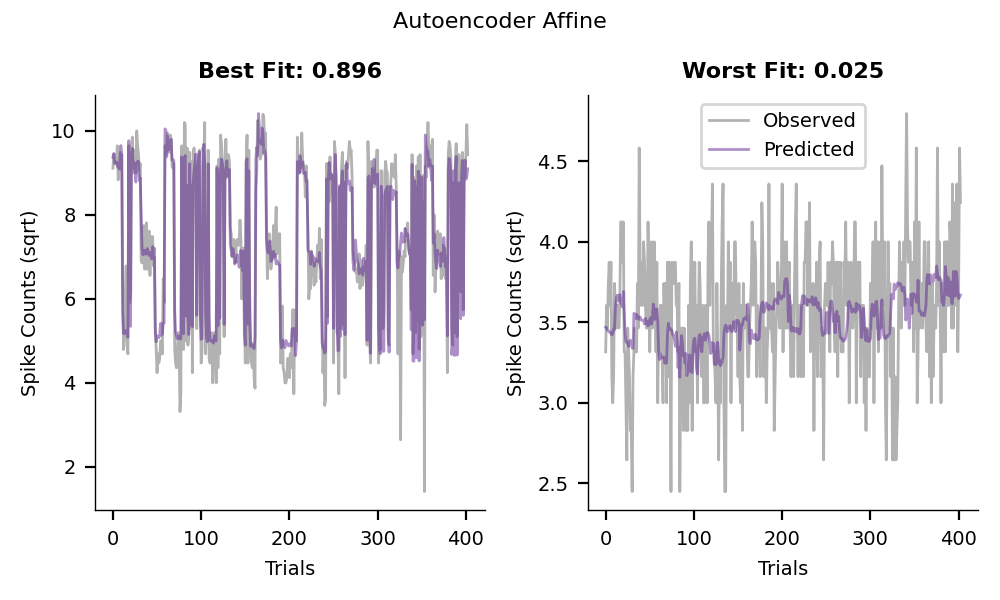

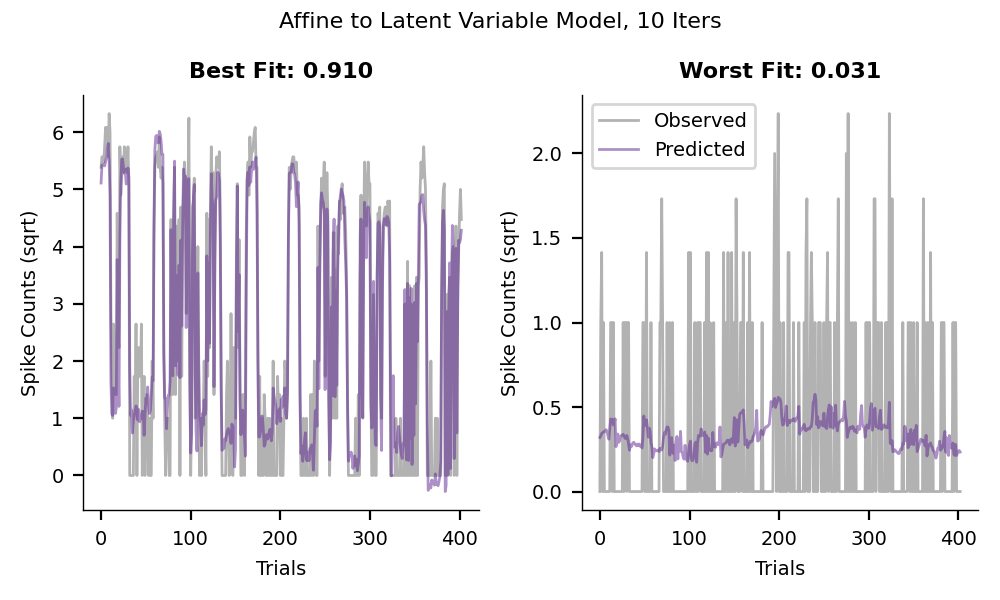

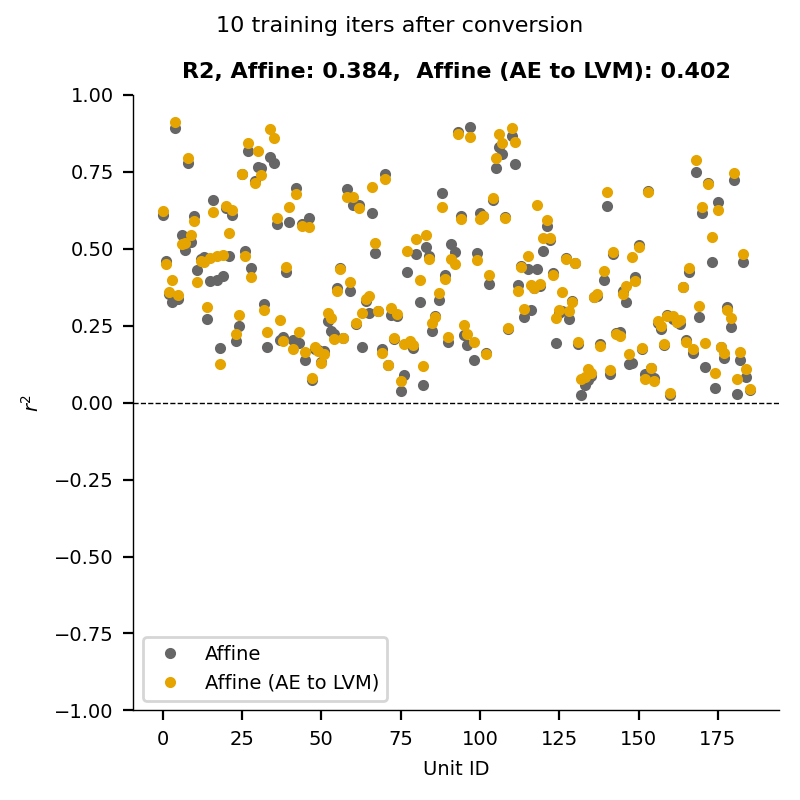

In [10]:
print("Step 4b: Eval")
res_affineae        = fitlvm_utils.eval_model(mod_ae_affine, data_gd, test_dl.dataset, model="Autoencoder Affine", do_plot=True, save=False)
res_affineaelvm     = fitlvm_utils.eval_model(mod_ae_affine_lvm, data_gd, test_dl.dataset, model="Affine to Latent Variable Model, 10 Iters", do_plot=True, save=False)
fitlvm_utils.plot_r2_comp(res_affineae, res_affineaelvm, label_a="Affine", label_b="Affine (AE to LVM)", title="10 training iters after conversion", save=False)

Step 4c: Eval


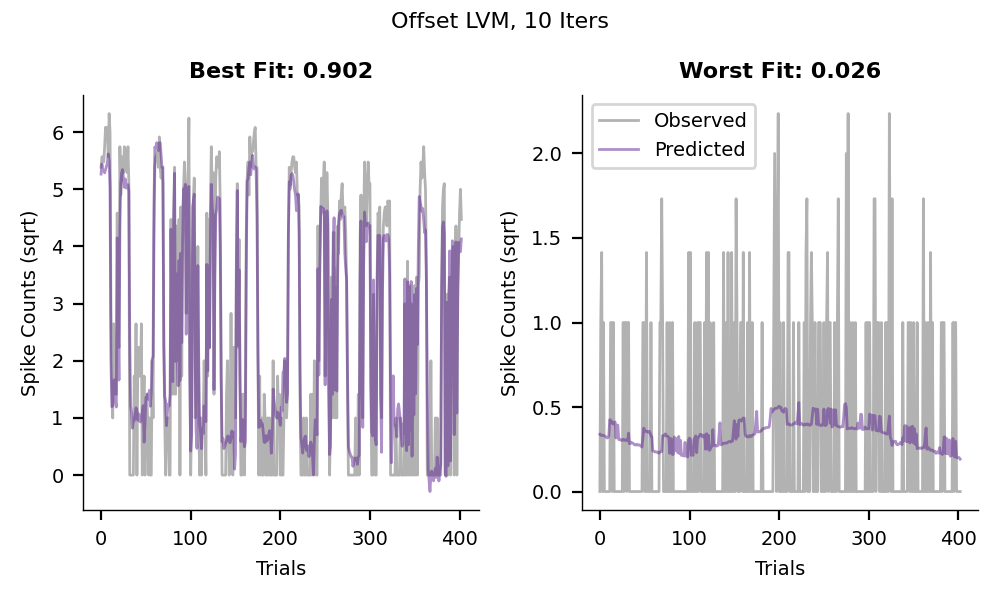

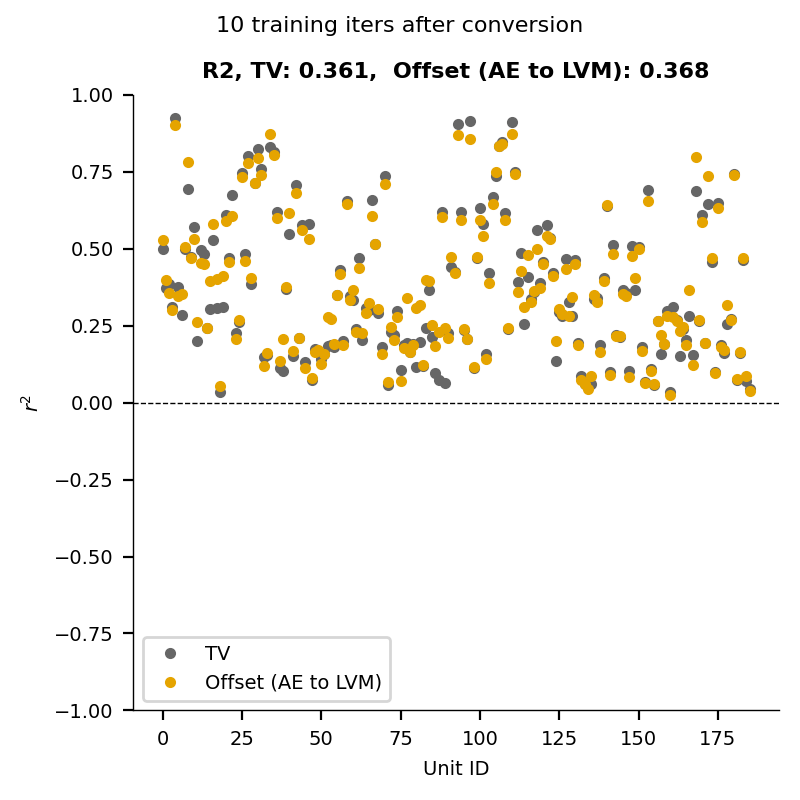

In [12]:
print("Step 4c: Eval")
res_offsetaelvm     = fitlvm_utils.eval_model(mod_ae_offset_lvm, data_gd, test_dl.dataset, model="Offset LVM, 10 Iters", do_plot=True, save=False)
fitlvm_utils.plot_r2_comp(res_tv, res_offsetaelvm, label_a="TV", label_b="Offset (AE to LVM)", title="10 training iters after conversion", save=False)

## Residuals

In [74]:
from copy import deepcopy
mod_offset_nolatent = deepcopy(mod_ae_offset_lvm)
mod_offset_nolatent.readout_offset.weight.data[:] = 0
res_offset_nolatent = fitlvm_utils.eval_model(mod_offset_nolatent, data_gd, test_dl.dataset)

robs = val_dl.dataset[:]['robs']
rhat = res_offset_nolatent['rhat']
res = robs - rhat

block_side = np.where(trial_data['block_side']=='left', 1, -1)
choice = trial_data['response']
reward = trial_data['rewarded']

rob_block_corr = utils.spearmanr_vec(block_side, robs)
rob_choice_corr = utils.spearmanr_vec(choice, robs)
rob_reward_corr = utils.spearmanr_vec(reward, robs)
res_block_corr = utils.spearmanr_vec(block_side, res)
res_choice_corr = utils.spearmanr_vec(choice, res)
res_reward_corr = utils.spearmanr_vec(reward, res)

C:\Users\danci\AppData\Local\Temp\ipykernel_3684\976828683.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  res = robs - rhat


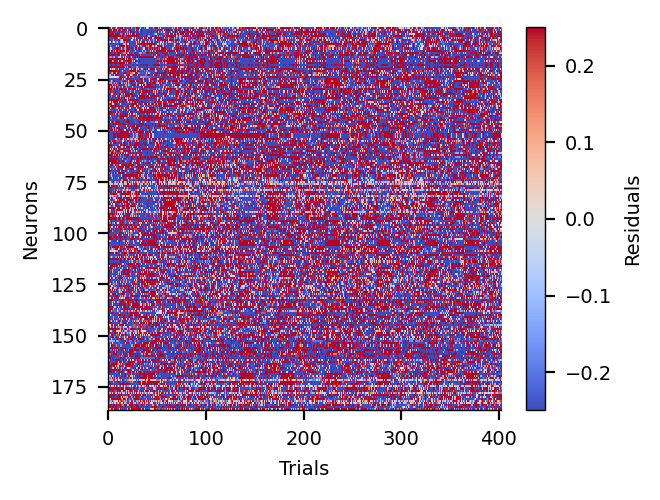

In [75]:
plt.figure()
plt.imshow(res.T, aspect='auto', interpolation='none', cmap='coolwarm', vmin=-0.25, vmax=0.25)
plt.colorbar(label="Residuals")
plt.xlabel("Trials"); plt.ylabel("Neurons")
plt.tight_layout(); plt.show()

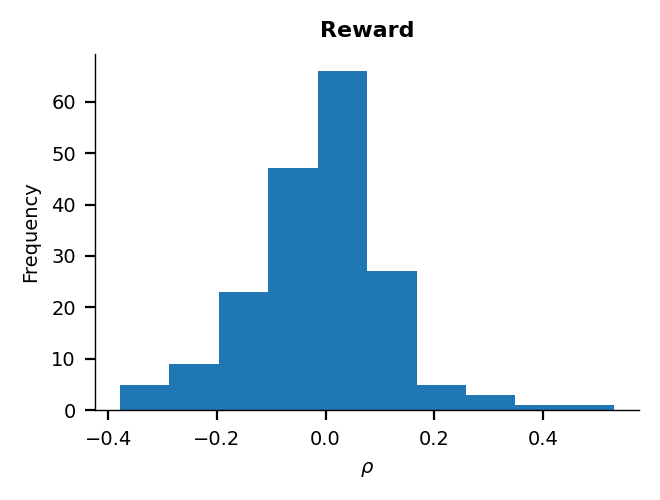

In [84]:
plt.figure() 
plt.hist(res_reward_corr)
plt.xlabel(r"$\rho$")
plt.ylabel("Frequency")
plt.title("Reward")
plt.tight_layout(); plt.show()

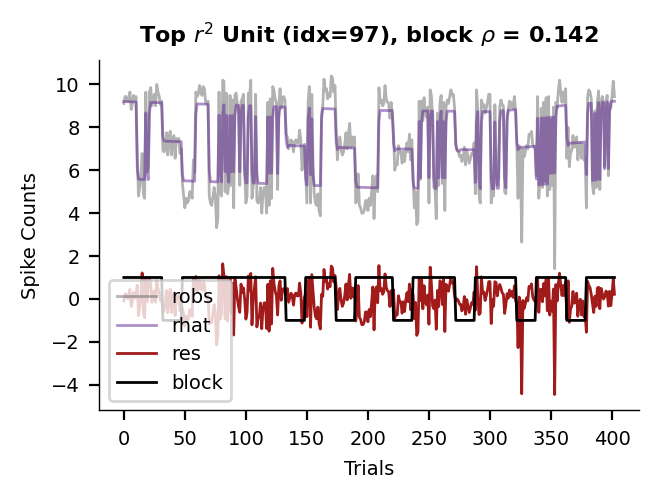

In [80]:
plt.figure()
plt.plot(robs[:,np.argmax(res_offset_nolatent['r2test'])], color="#666666", alpha=0.5, label="robs")
plt.plot(rhat[:,np.argmax(res_offset_nolatent['r2test'])], color="#5C2392", alpha=0.5, label="rhat")
plt.plot(res[:,np.argmax(res_offset_nolatent['r2test'])], color="#A11B1B", label="res")
plt.plot(block_side, color="#000000", label='block')
plt.xlabel("Trials")
plt.ylabel("Spike Counts")
plt.title(fr"Top $r^2$ Unit (idx={np.argmax(res_offset_nolatent['r2test'])}), block $\rho$ = {res_block_corr[np.argmax(res_offset_nolatent['r2test'])].round(3)}")
plt.legend()
plt.tight_layout(); plt.show()

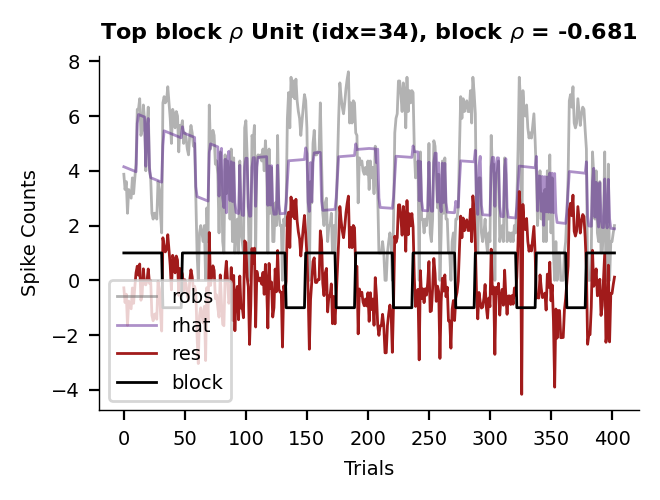

In [79]:
plt.figure()
plt.plot(robs[:,np.argmax(np.abs(res_block_corr))], color="#666666", alpha=0.5, label="robs")
plt.plot(rhat[:,np.argmax(np.abs(res_block_corr))], color="#5C2392", alpha=0.5, label="rhat")
plt.plot(res[:,np.argmax(np.abs(res_block_corr))], color="#A11B1B", label="res")
plt.plot(block_side, color="#000000", label='block')
plt.xlabel("Trials")
plt.ylabel("Spike Counts")
plt.title(fr"Top block $\rho$ Unit (idx={np.argmax(np.abs(res_block_corr))}), block $\rho$ = {res_block_corr[np.argmax(np.abs(res_block_corr))].round(3)}")
plt.legend()
plt.tight_layout(); plt.show()

In [ ]:
# try to freeze tv when training affine

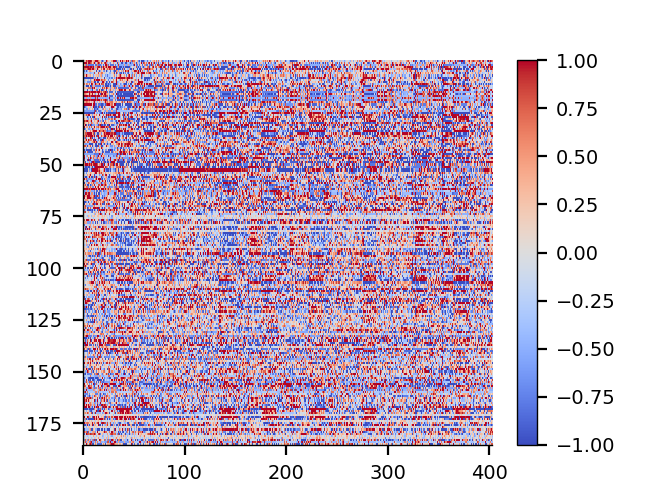

: 

In [ ]:
plt.figure(); plt.imshow(res.T, aspect='auto', interpolation='none', cmap='coolwarm', vmin=-1, vmax=1); plt.colorbar(); plt.show()

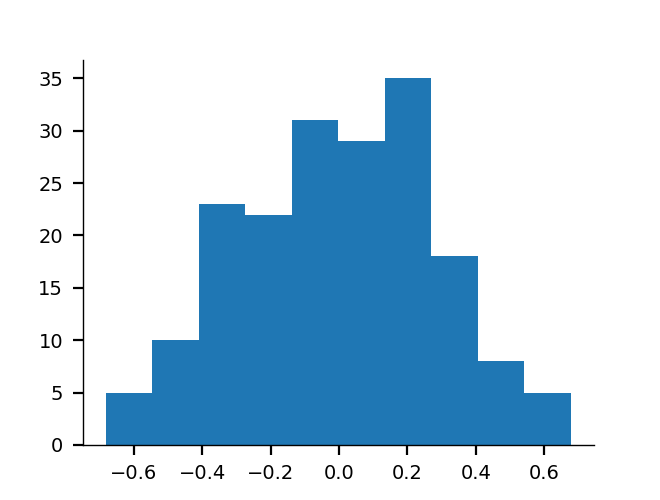

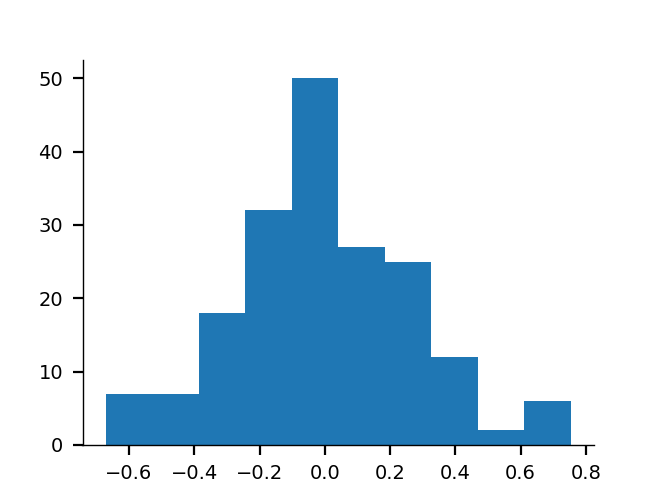

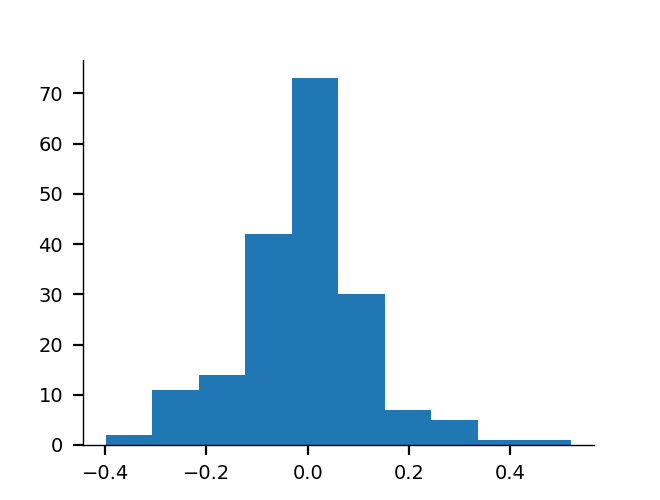

In [17]:
plt.figure(); plt.hist(res_block_corr); plt.show()
plt.figure(); plt.hist(res_choice_corr); plt.show()
plt.figure(); plt.hist(res_reward_corr); plt.show()

## Evaluation

In [10]:
# EVALUATION
print("Evaluating...")
das_sess = fitlvm_utils.get_das(trial_data, regions, sample, train_inds, val_inds, test_inds, train_dl, test_dl, mod_baseline, mod_tv, mod_ae_offset, mod_ae_gain, mod_ae_affine, mod_ae_offset_lvm, mod_ae_gain_lvm, mod_ae_affine_lvm, cids, data_gd, do_save=False, do_plot=True)

Evaluating...
Fitting CV PCA


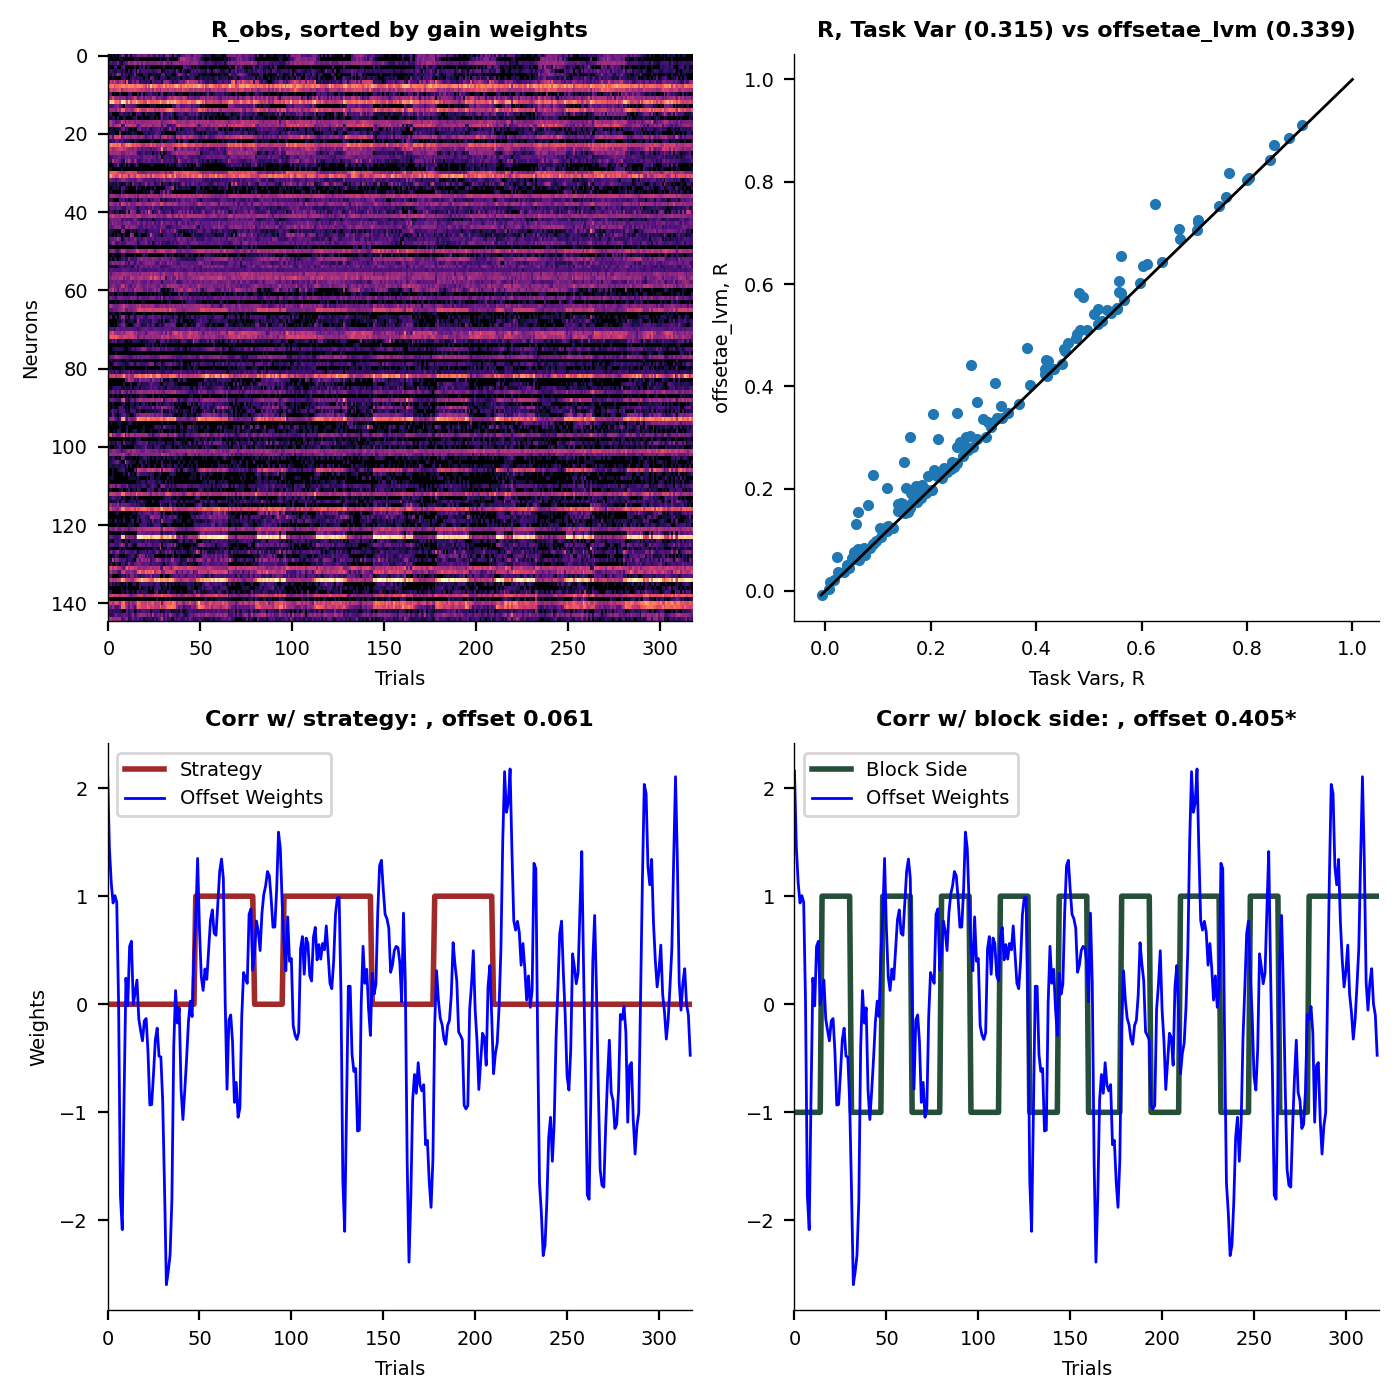

In [11]:
# offset
fitlvm_utils.plot_summary(das_sess, subj_idx=subj_idx, sess_idx=sess_idx, sort_by="offset", model_name="offsetae_lvm")

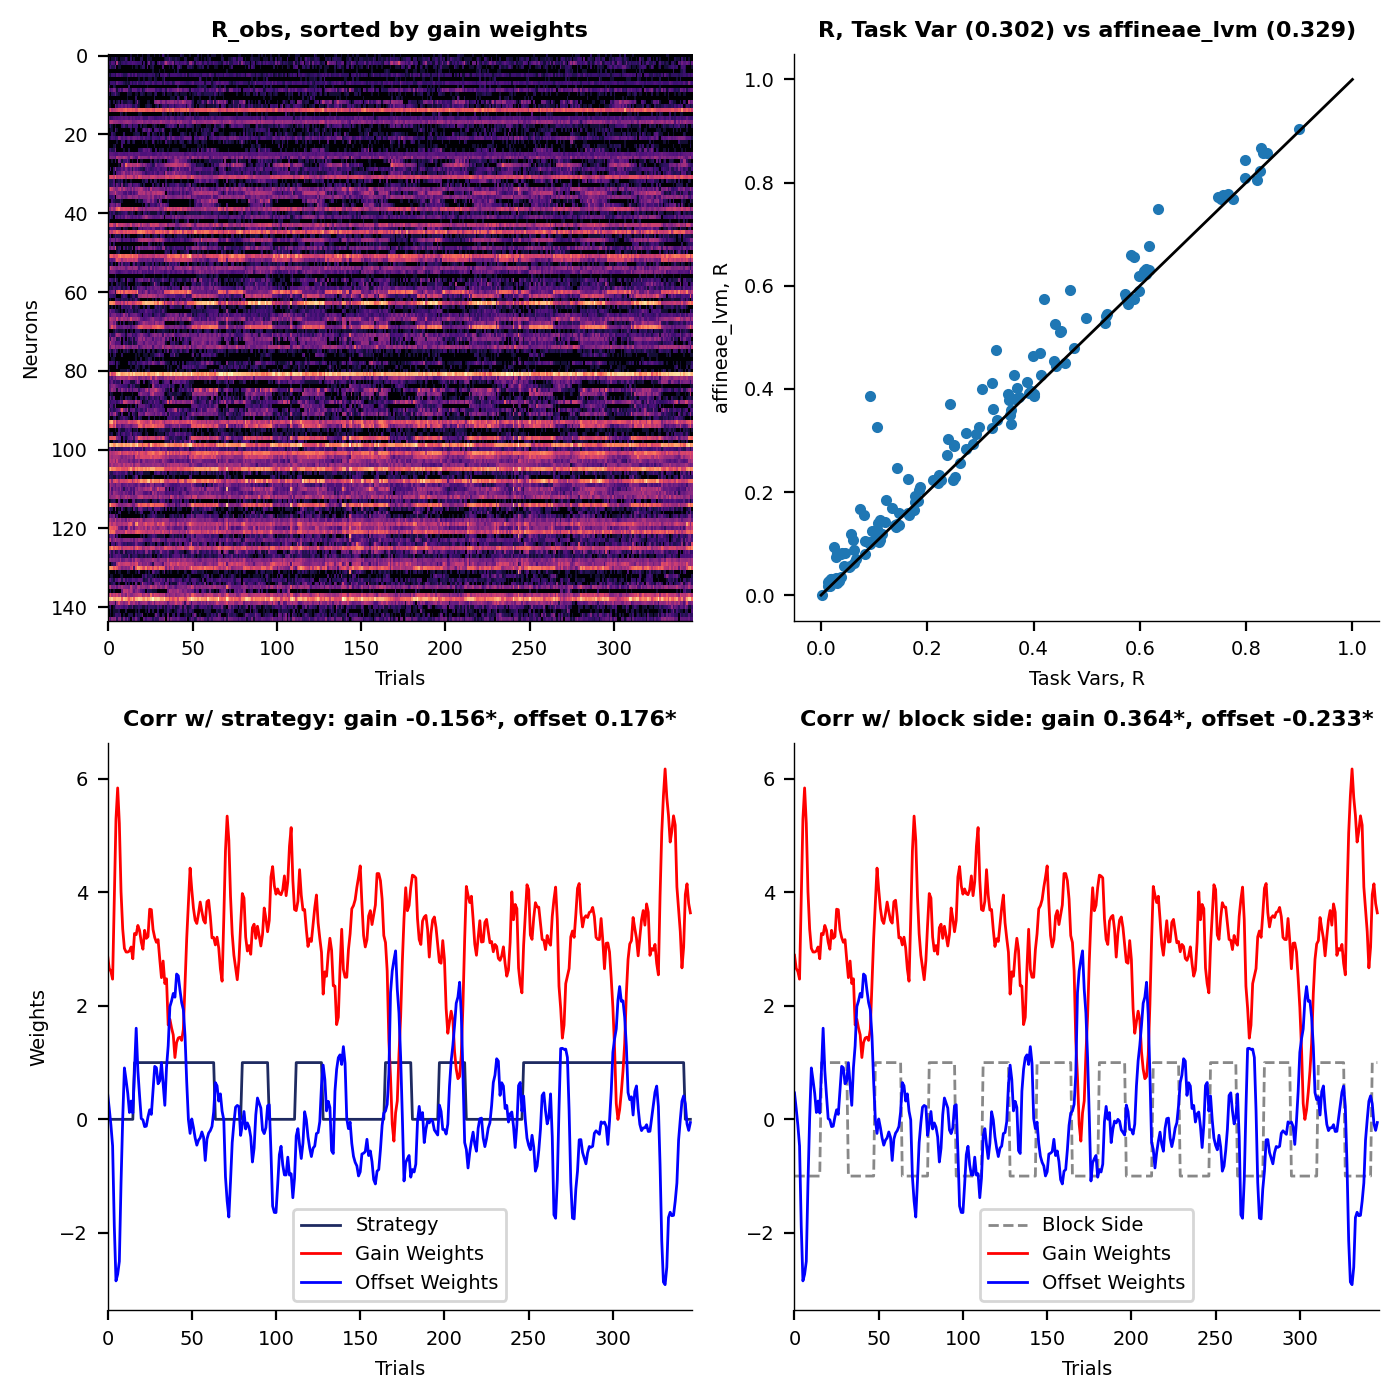

In [ ]:
# affine
fitlvm_utils.plot_summary(das_sess, subj_idx=subj_idx, sess_idx=sess_idx)

## Grid Search

In [17]:
# SERIAL
out = [fit_models.fit_sess(unit_spike_times_all[subj_idx][sess_idx], trial_data_all[subj_idx][sess_idx], session_data_all[subj_idx][sess_idx], regions_all[subj_idx][sess_idx], subj_idx, sess_idx, num_latents=latent_idx) for latent_idx in range(1,8+1)]
das = [out[latent_idx][0] for latent_idx in range(8)]

FileNotFoundError: [Errno 2] No such file or directory: 'logs/fit_sess_log.txt'

In [ ]:
# PARALLEL
def fit_sess_latents_gs(subj_idx, sess_idx):
    return Parallel(n_jobs=-1, backend='loky')(delayed(fit_models.fit_sess)(unit_spike_times_all[subj_idx][sess_idx], trial_data_all[subj_idx][sess_idx], session_data_all[subj_idx][sess_idx], regions_all[subj_idx][sess_idx], subj_idx, sess_idx, num_latents=num_latents) for num_latents in range(1,8+1))
out = fit_sess_latents_gs(subj_idx=subj_idx, sess_idx=sess_idx) 
das = [out[latent_idx][0] for latent_idx in range(8)]
np.save('vars/das_03_latents.npy', das)

In [ ]:
# PARALLEL
out = fit_sess_latents_gs(subj_idx=0, sess_idx=2) 
das = [out[latent_idx][0] for latent_idx in range(8)]
np.save('vars/das_02_latents.npy', das)

In [ ]:
# PARALLEL
out = fit_sess_latents_gs(subj_idx=0, sess_idx=1) 
das = [out[latent_idx][0] for latent_idx in range(8)]
np.save('vars/das_01_latents.npy', das)

In [ ]:
# PARALLEL
out = fit_sess_latents_gs(subj_idx=0, sess_idx=0) 
das = [out[latent_idx][0] for latent_idx in range(8)]
np.save('vars/das_00_latents.npy', das)

In [ ]:
# PARALLEL
out = fit_sess_latents_gs(subj_idx=0, sess_idx=4) 
das = [out[latent_idx][0] for latent_idx in range(8)]
np.save('vars/das_04_latents.npy', das)

In [ ]:
from lib import eval_models

In [ ]:
eval_models.plot_r2_laatents(das, subj_idx=0, sess_idx=3, is_msess=False)

In [ ]:
eval_models.plot_r2_latents(das, subj_idx=0, sess_idx=3, is_msess=False, ae=False)

In [ ]:
def bah(das, num_latents, ae=True, mult=True):
    plt.figure()
    model = das['affineae'] if ae else das['affine']
    weights = model['model'].gain_mu.get_weights() if mult else model['model'].offset_mu.get_weights() 
    for ax in range(num_latents):
        plt.plot(weights[:,ax], alpha=0.5, label=f"Latent {ax+1}")
    plt.title(f"Total # Latents: {num_latents}")
    plt.legend()

In [ ]:
for num_latents in range(1, 8+1): 
    bah(das[num_latents-1], num_latents=num_latents, ae=False)
     